In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, cross_val_score, cross_validate
from sklearn.preprocessing import OneHotEncoder, TargetEncoder
from sklearn.compose import make_column_transformer
from sklearn.decomposition import PCA
from ucimlrepo import fetch_ucirepo 
from operator import itemgetter

Статья про датасет: https://www.sciencedirect.com/science/article/pii/S2352340919306985?via%3Dihub

In [2]:
data = pd.read_csv('./ObesityDataSet.csv')
# переименование для наглядности
data = data.rename(columns={'FAVC': 'high_caloric_food_frequent', 'FCVC': 'vegetables_frequency', 'NCP': 'meals_a_day', 'CAEC': 'snacks', 'SCC': 'monitor_calories', 'FAF': 'days_of_physical_activity', 'TUE': 'hours_on_tech_devices', 'CALC': 'alcohol_frequency'})
data

,Gender,Age,Height,Weight,family_history_with_overweight,high_caloric_food_frequent,vegetables_frequency,meals_a_day,snacks,SMOKE,CH2O,monitor_calories,days_of_physical_activity,hours_on_tech_devices,alcohol_frequency,MTRANS,NObeyesdad
0,Female,21.000000,1.620000,64.000000,yes,no,2.0,3.0,Sometimes,no,2.000000,no,0.000000,1.000000,no,Public_Transportation,Normal_Weight
1,Female,21.000000,1.520000,56.000000,yes,no,3.0,3.0,Sometimes,yes,3.000000,yes,3.000000,0.000000,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.000000,1.800000,77.000000,yes,no,2.0,3.0,Sometimes,no,2.000000,no,2.000000,1.000000,Frequently,Public_Transportation,Normal_Weight
3,Male,27.000000,1.800000,87.000000,no,no,3.0,3.0,Sometimes,no,2.000000,no,2.000000,0.000000,Frequently,Walking,Overweight_Level_I
4,Male,22.000000,1.780000,89.800000,no,no,2.0,1.0,Sometimes,no,2.000000,no,0.000000,0.000000,Sometimes,Public_Transportation,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,Female,20.976842,1.710730,131.408528,yes,yes,3.0,3.0,Sometimes,no,1.728139,no,1.676269,0.906247,Sometimes,Public_Transportation,Obesity_Type_III
2107,Female,21.982942,1.748584,133.742943,yes,yes,3.0,3.0,Sometimes,no,2.005130,no,1.341390,0.599270,Sometimes,Public_Transportation,Obesity_Type_III
2108,Female,22.524036,1.752206,133.689352,yes,yes,3.0,3.0,Sometimes,no,2.054193,no,1.414209,0.646288,Sometimes,Public_Transportation,Obesity_Type_III
2109,Female,24.361936,1.739450,133.346641,yes,yes,3.0,3.0,Sometimes,no,2.852339,no,1.139107,0.586035,Sometimes,Public_Transportation,Obesity_Type_III


Берём все признаки, кроме определяемых (вес)

In [3]:
X = data.drop(['NObeyesdad', 'Weight'], axis=1)
X

,Gender,Age,Height,family_history_with_overweight,high_caloric_food_frequent,vegetables_frequency,meals_a_day,snacks,SMOKE,CH2O,monitor_calories,days_of_physical_activity,hours_on_tech_devices,alcohol_frequency,MTRANS
0,Female,21.000000,1.620000,yes,no,2.0,3.0,Sometimes,no,2.000000,no,0.000000,1.000000,no,Public_Transportation
1,Female,21.000000,1.520000,yes,no,3.0,3.0,Sometimes,yes,3.000000,yes,3.000000,0.000000,Sometimes,Public_Transportation
2,Male,23.000000,1.800000,yes,no,2.0,3.0,Sometimes,no,2.000000,no,2.000000,1.000000,Frequently,Public_Transportation
3,Male,27.000000,1.800000,no,no,3.0,3.0,Sometimes,no,2.000000,no,2.000000,0.000000,Frequently,Walking
4,Male,22.000000,1.780000,no,no,2.0,1.0,Sometimes,no,2.000000,no,0.000000,0.000000,Sometimes,Public_Transportation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,Female,20.976842,1.710730,yes,yes,3.0,3.0,Sometimes,no,1.728139,no,1.676269,0.906247,Sometimes,Public_Transportation
2107,Female,21.982942,1.748584,yes,yes,3.0,3.0,Sometimes,no,2.005130,no,1.341390,0.599270,Sometimes,Public_Transportation
2108,Female,22.524036,1.752206,yes,yes,3.0,3.0,Sometimes,no,2.054193,no,1.414209,0.646288,Sometimes,Public_Transportation
2109,Female,24.361936,1.739450,yes,yes,3.0,3.0,Sometimes,no,2.852339,no,1.139107,0.586035,Sometimes,Public_Transportation


Будем пытаться посчитать вес (не степень ожирения)

In [4]:
Y = data['Weight']
Y

0        64.000000
1        56.000000
2        77.000000
3        87.000000
4        89.800000
           ...    
2106    131.408528
2107    133.742943
2108    133.689352
2109    133.346641
2110    133.472641
Name: Weight, Length: 2111, dtype: float64

In [35]:
data['NObeyesdad'].value_counts()

NObeyesdad
Obesity_Type_I         351
Obesity_Type_III       324
Obesity_Type_II        297
Overweight_Level_I     290
Overweight_Level_II    290
Normal_Weight          287
Insufficient_Weight    272
Name: count, dtype: int64

In [5]:
X, Y = shuffle(X, Y, random_state=0)
X

,Gender,Age,Height,family_history_with_overweight,high_caloric_food_frequent,vegetables_frequency,meals_a_day,snacks,SMOKE,CH2O,monitor_calories,days_of_physical_activity,hours_on_tech_devices,alcohol_frequency,MTRANS
1730,Male,30.595632,1.910672,yes,yes,2.497548,3.000000,Sometimes,no,1.362583,no,1.144076,0.173232,Sometimes,Public_Transportation
259,Female,18.000000,1.670000,yes,yes,1.000000,3.000000,Frequently,no,1.000000,no,0.000000,1.000000,Sometimes,Public_Transportation
966,Male,29.153907,1.773656,no,yes,1.595746,3.618722,Sometimes,no,1.274389,no,1.504003,0.370067,no,Automobile
1911,Female,18.314593,1.745602,yes,yes,3.000000,3.000000,Sometimes,no,2.923792,no,1.536555,0.625350,Sometimes,Public_Transportation
1815,Female,18.771001,1.746652,yes,yes,3.000000,3.000000,Sometimes,no,2.869234,no,1.465931,0.627886,Sometimes,Public_Transportation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1033,Male,19.671876,1.699474,yes,no,1.925064,2.358298,Sometimes,no,2.774043,no,0.000000,0.133566,no,Public_Transportation
1731,Male,30.554956,1.779136,yes,yes,2.671238,3.000000,Sometimes,no,2.145368,no,0.882709,0.593917,Sometimes,Automobile
763,Male,21.000000,1.620000,no,yes,2.000000,1.000000,no,no,3.000000,no,1.000000,0.000000,Sometimes,Public_Transportation
835,Female,29.320380,1.642506,yes,yes,2.366949,3.000000,Sometimes,no,1.926577,no,1.581242,0.000000,Sometimes,Automobile


Кроссвалидация для регрессионных задач

In [6]:
def crossval(X,Y,model,n_splits):
    kf = KFold(n_splits)
    scor = [] # список точностей для перебираемых разбиений
    for train, test in kf.split(X):
        X_train, X_test, Y_train, Y_test = X.iloc[train], X.iloc[test], Y[train], Y[test]
        clf = model.fit(X_train,Y_train)
        q = clf.score(X_test, Y_test) # точность для рассматриваемого разбиения 
        q=r2_score(Y_test, clf.predict(X_test))
        scor.append(q)
    return np.array(scor).mean()

def crossval_one_feature(X,Y,model,n_splits):
    kf = KFold(n_splits)
    scor = [] # список точностей для перебираемых разбиений
    for train, test in kf.split(X):
        X_train, X_test, Y_train, Y_test = np.array(X.iloc[train]).reshape(-1, 1), np.array(X.iloc[test]).reshape(-1, 1), Y[train], Y[test]
        clf = model.fit(X_train,Y_train)
        q = clf.score(X_test, Y_test) # точность для рассматриваемого разбиения 
        scor.append(q)
    return np.array(scor).mean()

def crossval_staged(X,Y,model,n_splits):
    kf = KFold(n_splits)
    scor = []
    for train, test in kf.split(X):
        X_train, X_test, Y_train, Y_test = X.iloc[train], X.iloc[test], Y[train], Y[test]
        clf = model.fit(X_train,Y_train)
        q = np.array([r2_score(Y_pred, Y_test) for Y_pred in clf.staged_predict(X_test)])
        scor.append(q)
    return np.array(scor)

## 1. Линейная регрессия

In [7]:
X_numeric = X[['Age', 'Height', 'vegetables_frequency', 'meals_a_day', 'CH2O', 'days_of_physical_activity', 'hours_on_tech_devices']]
X_numeric

,Age,Height,vegetables_frequency,meals_a_day,CH2O,days_of_physical_activity,hours_on_tech_devices
1730,30.595632,1.910672,2.497548,3.000000,1.362583,1.144076,0.173232
259,18.000000,1.670000,1.000000,3.000000,1.000000,0.000000,1.000000
966,29.153907,1.773656,1.595746,3.618722,1.274389,1.504003,0.370067
1911,18.314593,1.745602,3.000000,3.000000,2.923792,1.536555,0.625350
1815,18.771001,1.746652,3.000000,3.000000,2.869234,1.465931,0.627886
...,...,...,...,...,...,...,...
1033,19.671876,1.699474,1.925064,2.358298,2.774043,0.000000,0.133566
1731,30.554956,1.779136,2.671238,3.000000,2.145368,0.882709,0.593917
763,21.000000,1.620000,2.000000,1.000000,3.000000,1.000000,0.000000
835,29.320380,1.642506,2.366949,3.000000,1.926577,1.581242,0.000000


Коэффициент R^2 - показатель точности Линейной Регрессии: 1.0 - если все точки лежат на построенной прямой, 0.0 - если построенная прямая - y=среднее_значение; <0.0 - если предсказание хуже, чем если бы предсказывали бы среднее значение

In [169]:
clf = LinearRegression()
clf.fit(X_numeric, Y)

print("R^2 for train: ", clf.score(X_numeric, Y))
print("R^2 for my CV: ", crossval(X_numeric, Y, clf, 5))
print("R^2 for built-in CV: ", cross_val_score(clf, X_numeric, Y, scoring="r2", cv=5).mean())
# scores = cross_validate(clf, X_numeric, Y, scoring="r2", cv=5, return_estimator=True, return_indices=True)
# print("R^2 for built-in CV1: ", scores['test_score'])
# print("\t\t\t\ttest\t\t\ttrain\t\t\tall")
# for i in range(5):
#     test = scores['indices']['test'][i]
#     train = scores['indices']['train'][i]
#     X_train, X_test, Y_train, Y_test = X_numeric.iloc[train], X_numeric.iloc[test], Y[train], Y[test]
#     clf = clf.fit(X_train,Y_train)
#     q = clf.score(X_test, Y_test) # точность для рассматриваемого разбиения 
#     q_t = clf.score(X_train, Y_train) # точность для рассматриваемого разбиения 
#     q_a = clf.score(X_numeric, Y) # точность для рассматриваемого разбиения 
#     q1 = scores['estimator'][i].score(X_test,Y_test)
#     q1_t = scores['estimator'][i].score(X_train,Y_train)
#     q1_a = scores['estimator'][i].score(X_numeric,Y)
#     q2 = r2_score(Y_test, scores['estimator'][i].predict(X_test))
#     q2_t = r2_score(Y_train, scores['estimator'][i].predict(X_train))
#     q2_a = r2_score(Y, scores['estimator'][i].predict(X_numeric))
#     q3 = 1-(1-q1)*(X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)
#     q3_t = 1-(1-q1_t)*(X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1)
#     q3_a = 1-(1-q1_a)*(X_numeric.shape[0]-1)/(X_numeric.shape[0]-X_numeric.shape[1]-1)
#     q4 = 1-(1-q2)*(X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)
#     q4_t = 1-(1-q2_t)*(X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1)
#     q4_a = 1-(1-q2_a)*(X_numeric.shape[0]-1)/(X_numeric.shape[0]-X_numeric.shape[1]-1)
#     print(i)
#     print("\t self taught model:", q, q_t, q_a)
#     print("\t built-in model + self.score:", q1, q1_t, q1_a)
#     print("\t built-in model + self.score + adj:", q3, q3_t, q3_a)
#     print("\t built-in model + r2_score:", q2, q2_t, q2_a)
#     print("\t built-in model + r2_score + adj:", q4, q4_t, q4_a)
    

print("R^2 for individual features for my CV:")
for feature in X_numeric:
    print(f"\t {feature}:", crossval_one_feature(X_numeric[feature], Y, clf, 5))
    
print("R^2 for individual features for built-in CV:")
for feature in X_numeric:
    print(f"\t {feature}:", cross_val_score(clf, np.array(X_numeric[feature]).reshape(-1,1), Y, scoring="r2", cv=5).mean())

R^2 for train:  0.3577841872604539
R^2 for my CV:  -3.2255947963350122
R^2 for built-in CV:  0.34804106220751685
R^2 for individual features for my CV:
	 Age: -3.2153468797113254
	 Height: -3.2090407116196906
	 vegetables_frequency: -3.2015284029485365
	 meals_a_day: -3.208664274410439
	 CH2O: -3.207967469671472
	 days_of_physical_activity: -3.2047798234877165
	 hours_on_tech_devices: -3.2077519327578763
R^2 for individual features for built-in CV:
	 Age: 0.03328805467432503
	 Height: 0.2069780620747202
	 vegetables_frequency: 0.0377128079904568
	 meals_a_day: 0.0026711153969947166
	 CH2O: 0.03167096517749237
	 days_of_physical_activity: -0.005640726433526666
	 hours_on_tech_devices: -0.0029716450364027703


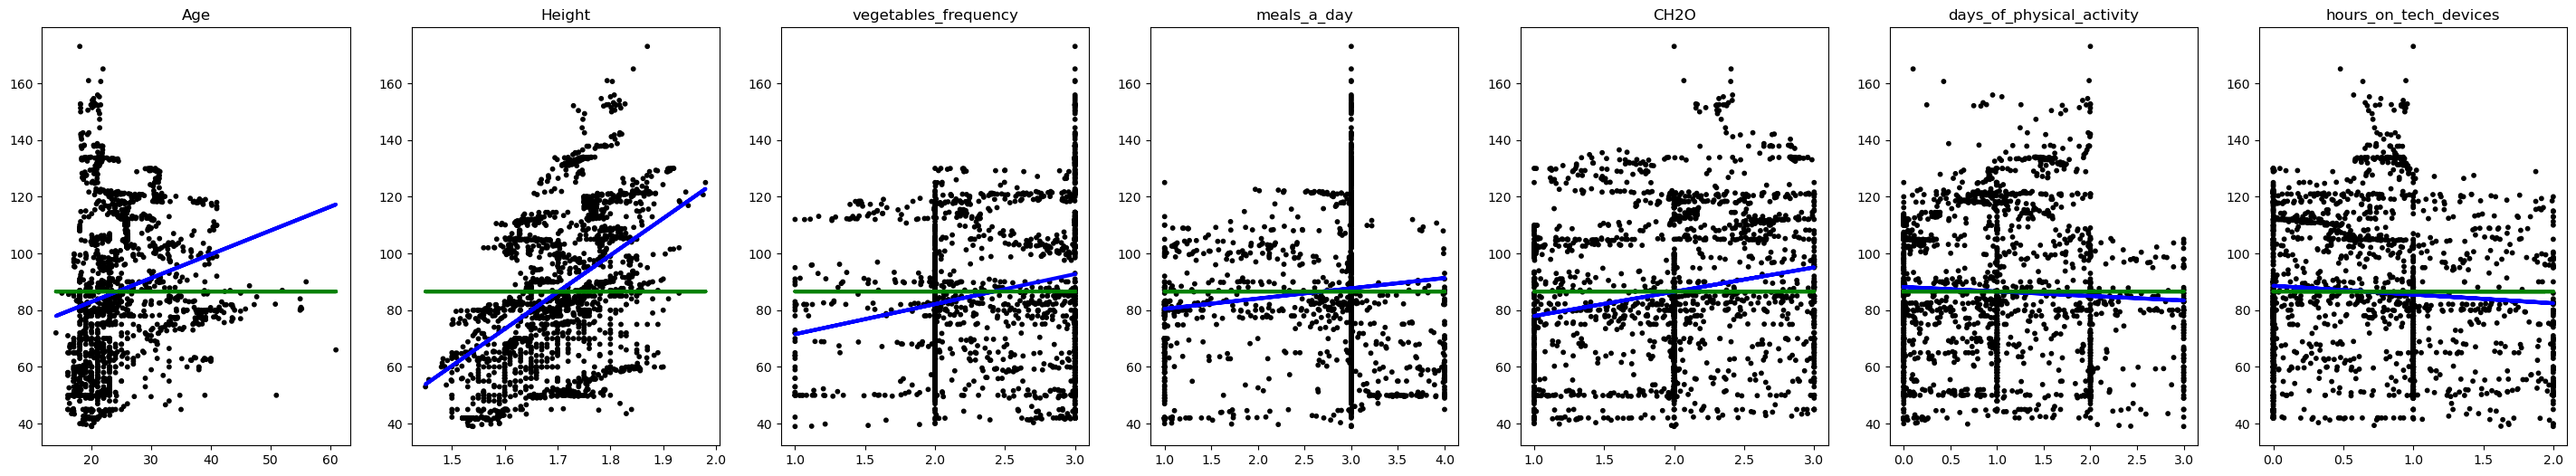

In [146]:
features_count = X_numeric.shape[1] # number of features
fig, axs = plt.subplots(1, features_count, figsize=(36,6)) # all graphs for pairs of fetures
plot_number = 0 # current plot id

for feature in X_numeric:
    ax = axs[plot_number]
    plot_number+=1
    clf.fit(np.array(X_numeric[feature]).reshape(-1, 1), Y)
    ax.scatter(X_numeric[feature], Y, color="black", s=[10]*Y.shape[0])
    ax.plot(X_numeric[feature], clf.predict(np.array(X_numeric[feature]).reshape(-1, 1)), color="blue", linewidth=3)
    ax.plot(X_numeric[feature], [Y.mean()]*Y.shape[0], color="green", linewidth=3)
    ax.set_title(feature)

## 2. Бустинг

Немного подбора параметров с использованием встроенной кроссвалидации без оптимизации staged_predict

In [203]:
accs = []
for depth in range(1,7):
    n_acc = []
    for n in range(100, 500, 100):
        model_r = GradientBoostingRegressor(n_estimators=n, learning_rate=0.1, max_depth=depth, random_state=0)
        res = cross_val_score(model_r, X_numeric, Y, scoring="r2", cv=5).mean()
        n_acc.append((n, res))
        
    accs.append((depth, n_acc))
    
accs

[(1,
  [(100, 0.5735247696199272),
   (200, 0.6139360867323995),
   (300, 0.624550874202399),
   (400, 0.6298209306331737)]),
 (2,
  [(100, 0.6792856497214207),
   (200, 0.7046510153677664),
   (300, 0.718422820319996),
   (400, 0.7251931936345855)]),
 (3,
  [(100, 0.7460553987862328),
   (200, 0.7665832495338709),
   (300, 0.7733338006447428),
   (400, 0.775846011749546)]),
 (4,
  [(100, 0.7857093927316099),
   (200, 0.7969061815561471),
   (300, 0.7981148676001546),
   (400, 0.7981257283968682)]),
 (5,
  [(100, 0.8152381705916533),
   (200, 0.8199296874766814),
   (300, 0.8198293325312873),
   (400, 0.818692581637116)]),
 (6,
  [(100, 0.8389852343510713),
   (200, 0.8396673213290665),
   (300, 0.8385401545658796),
   (400, 0.8377088222090805)])]

In [204]:
accs = []
for depth in range(7,10):
    n_acc = []
    for n in range(200, 500, 100):
        model_r = GradientBoostingRegressor(n_estimators=n, learning_rate=0.1, max_depth=depth, random_state=0)
        res = cross_val_score(model_r, X_numeric, Y, scoring="r2", cv=5).mean()
        n_acc.append((n, res))
        
    accs.append((depth, n_acc))
    
accs # best is 300, 9

[(7,
  [(200, 0.8507692510938876),
   (300, 0.8507915153295587),
   (400, 0.8502813436717901)]),
 (8,
  [(200, 0.8547301105160454),
   (300, 0.8544655327324225),
   (400, 0.8542778532218076)]),
 (9,
  [(200, 0.8507636562738219),
   (300, 0.8506884900251757),
   (400, 0.8506529571822435)])]

## 3. Encoding

### OneHot

In [8]:
categorical_cols = ['Gender', 'family_history_with_overweight', 'high_caloric_food_frequent', 'snacks', 'SMOKE', 'monitor_calories', 'alcohol_frequency', 'MTRANS']

In [9]:
transformer = make_column_transformer(
    (OneHotEncoder(), categorical_cols),
    remainder='passthrough')
transformed = transformer.fit_transform(X)
X_oh = pd.DataFrame(transformed, columns=transformer.get_feature_names_out())
X_oh

,onehotencoder__Gender_Female,onehotencoder__Gender_Male,onehotencoder__family_history_with_overweight_no,onehotencoder__family_history_with_overweight_yes,onehotencoder__high_caloric_food_frequent_no,onehotencoder__high_caloric_food_frequent_yes,onehotencoder__snacks_Always,onehotencoder__snacks_Frequently,onehotencoder__snacks_Sometimes,onehotencoder__snacks_no,...,onehotencoder__MTRANS_Motorbike,onehotencoder__MTRANS_Public_Transportation,onehotencoder__MTRANS_Walking,remainder__Age,remainder__Height,remainder__vegetables_frequency,remainder__meals_a_day,remainder__CH2O,remainder__days_of_physical_activity,remainder__hours_on_tech_devices
0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,30.595632,1.910672,2.497548,3.000000,1.362583,1.144076,0.173232
1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,18.000000,1.670000,1.000000,3.000000,1.000000,0.000000,1.000000
2,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,29.153907,1.773656,1.595746,3.618722,1.274389,1.504003,0.370067
3,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,18.314593,1.745602,3.000000,3.000000,2.923792,1.536555,0.625350
4,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,18.771001,1.746652,3.000000,3.000000,2.869234,1.465931,0.627886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,19.671876,1.699474,1.925064,2.358298,2.774043,0.000000,0.133566
2107,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,30.554956,1.779136,2.671238,3.000000,2.145368,0.882709,0.593917
2108,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,21.000000,1.620000,2.000000,1.000000,3.000000,1.000000,0.000000
2109,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,29.320380,1.642506,2.366949,3.000000,1.926577,1.581242,0.000000


In [234]:
accs = []
for depth in range(7,10):
    n_acc = []
    for n in range(200, 500, 100):
        model_r = GradientBoostingRegressor(n_estimators=n, learning_rate=0.1, max_depth=depth, random_state=0)
        res = cross_val_score(model_r, X_oh, Y, scoring="r2", cv=5).mean()
        n_acc.append((n, res))
        
    accs.append((depth, n_acc))
    
accs # best is 300, 7

[(7,
  [(200, 0.890637675515259),
   (300, 0.8906975561043755),
   (400, 0.8906224129552631)]),
 (8,
  [(200, 0.8861763742148515),
   (300, 0.8864039769964573),
   (400, 0.8864312895226387)]),
 (9,
  [(200, 0.8786261454134717),
   (300, 0.8786643775711503),
   (400, 0.8786584168092608)])]

In [235]:
accs = []
for depth in range(4,7):
    n_acc = []
    for n in range(200, 500, 100):
        model_r = GradientBoostingRegressor(n_estimators=n, learning_rate=0.1, max_depth=depth, random_state=0)
        res = cross_val_score(model_r, X_oh, Y, scoring="r2", cv=5).mean()
        n_acc.append((n, res))
        
    accs.append((depth, n_acc))
    
accs # best is 300, 7

[(4,
  [(200, 0.8610009492324284),
   (300, 0.8624727279259767),
   (400, 0.8627316602285534)]),
 (5,
  [(200, 0.8714971436445815),
   (300, 0.8728949401944522),
   (400, 0.8732255255346685)]),
 (6,
  [(200, 0.8865692167009545),
   (300, 0.8869161179970104),
   (400, 0.8868439766313176)])]

Посмотрим самые значимые параметры

In [10]:
clf = GradientBoostingRegressor(n_estimators=300, learning_rate=0.1, max_depth=7, random_state=0)
clf.fit(X_oh, Y)
named_impurity_importances = list(zip(X_oh.columns, clf.feature_importances_)) # скрепляем значимость параметров с их именами
sorted(named_impurity_importances,key=itemgetter(1), reverse=True) # сортируем по их значимости

[('remainder__Height', 0.1569400341190011),
 ('onehotencoder__family_history_with_overweight_yes', 0.1490957902819453),
 ('remainder__vegetables_frequency', 0.10839715808950662),
 ('onehotencoder__family_history_with_overweight_no', 0.09683505061748204),
 ('remainder__Age', 0.07249997798375812),
 ('remainder__meals_a_day', 0.07163000378223805),
 ('remainder__days_of_physical_activity', 0.07091721207911769),
 ('onehotencoder__snacks_Sometimes', 0.06687364089277509),
 ('remainder__hours_on_tech_devices', 0.05170092841601128),
 ('onehotencoder__Gender_Female', 0.03507108233730228),
 ('onehotencoder__Gender_Male', 0.03307610481444142),
 ('remainder__CH2O', 0.022139560423588014),
 ('onehotencoder__alcohol_frequency_Sometimes', 0.02032695978728968),
 ('onehotencoder__MTRANS_Public_Transportation', 0.013100729910113903),
 ('onehotencoder__alcohol_frequency_no', 0.01059072752595193),
 ('onehotencoder__high_caloric_food_frequent_yes', 0.004728820622603958),
 ('onehotencoder__MTRANS_Automobile',

### Target

In [11]:
transformer = make_column_transformer(
    (TargetEncoder(target_type="continuous"), categorical_cols),
    remainder='passthrough')
transformed = transformer.fit_transform(X, Y)
X_t = pd.DataFrame(transformed, columns=transformer.get_feature_names_out())
X_t

,targetencoder__Gender,targetencoder__family_history_with_overweight,targetencoder__high_caloric_food_frequent,targetencoder__snacks,targetencoder__SMOKE,targetencoder__monitor_calories,targetencoder__alcohol_frequency,targetencoder__MTRANS,remainder__Age,remainder__Height,remainder__vegetables_frequency,remainder__meals_a_day,remainder__CH2O,remainder__days_of_physical_activity,remainder__hours_on_tech_devices
0,89.973321,92.403124,88.684238,90.761334,85.948454,87.193758,90.735442,86.925599,30.595632,1.910672,2.497548,3.000000,1.362583,1.144076,0.173232
1,82.785328,92.752101,89.559938,58.389222,86.612404,87.854218,91.530449,87.784674,18.000000,1.670000,1.000000,3.000000,1.000000,0.000000,1.000000
2,90.889864,58.665301,88.750443,91.007047,86.259355,87.436150,76.487653,85.336191,29.153907,1.773656,1.595746,3.618722,1.274389,1.504003,0.370067
3,82.106570,92.819514,89.222263,91.480339,86.545745,87.855301,91.321153,87.593822,18.314593,1.745602,3.000000,3.000000,2.923792,1.536555,0.625350
4,82.715843,93.029596,89.626694,92.021385,87.072467,88.358237,92.364423,87.957170,18.771001,1.746652,3.000000,3.000000,2.869234,1.465931,0.627886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,91.035194,92.819514,66.612633,91.480339,86.545745,87.855301,77.192515,87.593822,19.671876,1.699474,1.925064,2.358298,2.774043,0.000000,0.133566
2107,91.497480,93.029596,89.626694,92.021385,87.072467,88.358237,92.364423,86.906278,30.554956,1.779136,2.671238,3.000000,2.145368,0.882709,0.593917
2108,91.497480,59.992274,89.626694,68.364007,87.072467,88.358237,92.364423,87.957170,21.000000,1.620000,2.000000,1.000000,3.000000,1.000000,0.000000
2109,82.106570,92.819514,89.222263,91.480339,86.545745,87.855301,91.321153,86.195334,29.320380,1.642506,2.366949,3.000000,1.926577,1.581242,0.000000


In [242]:
accs = []
for depth in range(4,10):
    n_acc = []
    for n in range(200, 500, 100):
        model_r = GradientBoostingRegressor(n_estimators=n, learning_rate=0.1, max_depth=depth, random_state=0)
        res = cross_val_score(model_r, X_t, Y, scoring="r2", cv=5).mean()
        n_acc.append((n, res))
        
    accs.append((depth, n_acc))
    
accs # best is 300, 8

[(4,
  [(200, 0.8560633927447163),
   (300, 0.858510945707741),
   (400, 0.8586264319414422)]),
 (5,
  [(200, 0.8704993021254468),
   (300, 0.8713105316686536),
   (400, 0.8718708102825763)]),
 (6,
  [(200, 0.8771595404201665),
   (300, 0.8772817328845447),
   (400, 0.8775694368611326)]),
 (7,
  [(200, 0.8869708437232108),
   (300, 0.8871780417551642),
   (400, 0.887180915809374)]),
 (8,
  [(200, 0.8818574730930262),
   (300, 0.8818922295038474),
   (400, 0.8818768563508608)]),
 (9,
  [(200, 0.8725546865876522),
   (300, 0.8725901890903545),
   (400, 0.8725888736874822)])]

In [12]:
clf = GradientBoostingRegressor(n_estimators=300, learning_rate=0.1, max_depth=8, random_state=0)
clf.fit(X_t, Y)
named_impurity_importances = list(zip(X_t.columns, clf.feature_importances_)) # скрепляем значимость параметров с их именами
sorted(named_impurity_importances,key=itemgetter(1), reverse=True) # сортируем по их значимости

[('targetencoder__family_history_with_overweight', 0.24790911041051553),
 ('remainder__Height', 0.15466742883265425),
 ('remainder__vegetables_frequency', 0.10744936974214747),
 ('targetencoder__snacks', 0.07776999640566215),
 ('remainder__days_of_physical_activity', 0.07616309640099049),
 ('targetencoder__Gender', 0.06974064751603269),
 ('remainder__Age', 0.06844954664513611),
 ('remainder__meals_a_day', 0.06155420048035022),
 ('remainder__hours_on_tech_devices', 0.05773568896279775),
 ('targetencoder__alcohol_frequency', 0.03090953709078021),
 ('remainder__CH2O', 0.01914862823198471),
 ('targetencoder__MTRANS', 0.014892745986176526),
 ('targetencoder__high_caloric_food_frequent', 0.00880834378992462),
 ('targetencoder__monitor_calories', 0.003466003781176004),
 ('targetencoder__SMOKE', 0.0013356557236711955)]

## PCA

In [27]:
pca_t = PCA(n_components=2).fit(X_t)
X_t_pca = pca_t.transform(X_t)
X_t_pca

array([[ -8.3077244 ,  -1.24408462],
       [  9.57034678,  25.18529336],
       [ 19.92381925, -16.71857775],
       ...,
       [ 30.81059282,  -0.60213056],
       [ -8.71852084,  -1.73574401],
       [ -7.96053746,  -1.50114432]])

In [28]:
pca_oh = PCA(n_components=2).fit(X_oh)
X_oh_pca = pca_oh.transform(X_oh)
X_oh_pca

array([[ 6.27398457,  0.32408953],
       [-6.31536183, -1.25511362],
       [ 4.87059949,  1.12686616],
       ...,
       [-3.32292294, -0.35113444],
       [ 5.06520403,  0.3906766 ],
       [ 0.10507647,  0.18798519]])

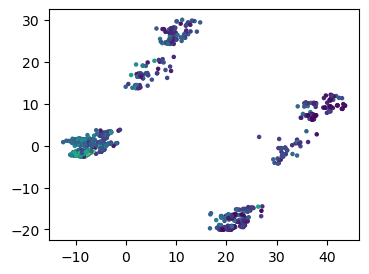

In [29]:
fig = plt.figure(1, figsize=(4, 3))
ax = fig.add_subplot()
ax.scatter(X_t_pca[:, 0], X_t_pca[:, 1], c=Y, s=[5]*Y.shape[0])

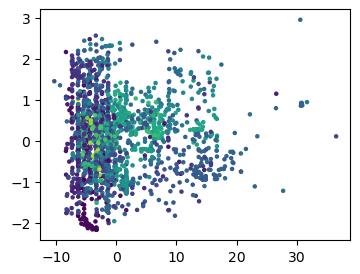

In [30]:
fig = plt.figure(1, figsize=(4, 3))
ax = fig.add_subplot()
ax.scatter(X_oh_pca[:, 0], X_oh_pca[:, 1], c=Y, s=[5]*Y.shape[0])

In [36]:
pca_oh = PCA(n_components=2).fit(X_numeric)
X_num_pca = pca_oh.transform(X_numeric)
X_num_pca

array([[ 6.29148558,  0.25364891],
       [-6.29763127, -1.1299697 ],
       [ 4.83367869,  0.75707235],
       ...,
       [-3.28707236, -0.67227248],
       [ 5.01077822,  0.70364015],
       [ 0.11169338,  0.01063929]])

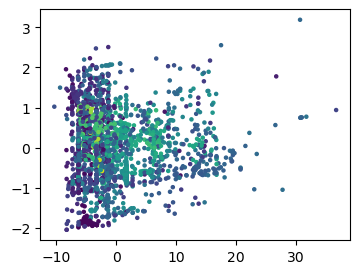

In [37]:
fig = plt.figure(1, figsize=(4, 3))
ax = fig.add_subplot()
ax.scatter(X_num_pca[:, 0], X_num_pca[:, 1], c=Y, s=[5]*Y.shape[0])

In [31]:
clf = LinearRegression()
clf.fit(X_oh, Y)
cross_val_score(clf, X_oh, Y, scoring="r2", cv=5).mean()

0.5738441950552748

In [32]:
clf.fit(X_t, Y)
cross_val_score(clf, X_t, Y, scoring="r2", cv=5).mean()

0.5428350805677057

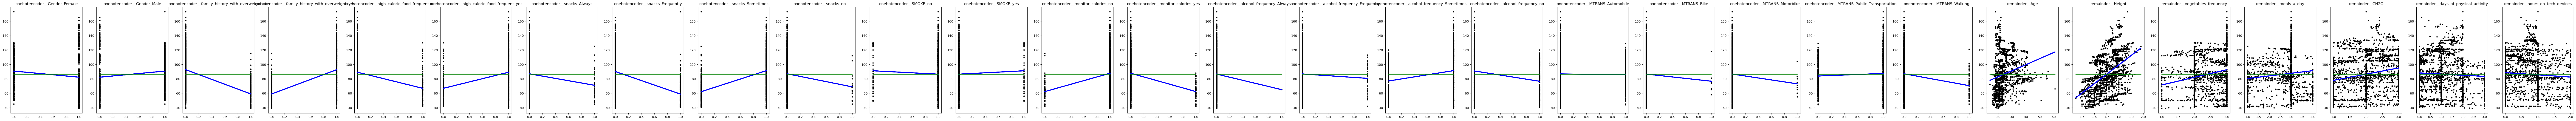

In [25]:
features_count = X_oh.shape[1] # number of features
fig, axs = plt.subplots(1, features_count, figsize=(144,6)) # all graphs for pairs of fetures
plot_number = 0 # current plot id

for feature in X_oh:
    ax = axs[plot_number]
    plot_number+=1
    clf.fit(np.array(X_oh[feature]).reshape(-1, 1), Y)
    ax.scatter(X_oh[feature], Y, color="black", s=[10]*Y.shape[0])
    ax.plot(X_oh[feature], clf.predict(np.array(X_oh[feature]).reshape(-1, 1)), color="blue", linewidth=3)
    ax.plot(X_oh[feature], [Y.mean()]*Y.shape[0], color="green", linewidth=3)
    ax.set_title(feature)

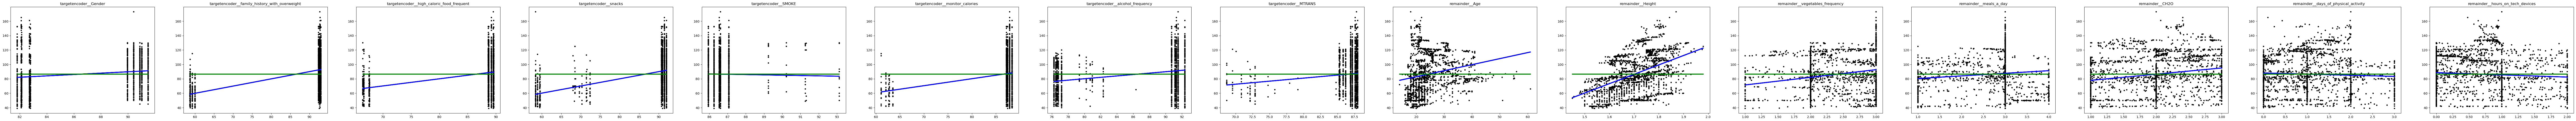

In [26]:
features_count = X_t.shape[1] # number of features
fig, axs = plt.subplots(1, features_count, figsize=(144,6)) # all graphs for pairs of fetures
plot_number = 0 # current plot id

for feature in X_t:
    ax = axs[plot_number]
    plot_number+=1
    clf.fit(np.array(X_t[feature]).reshape(-1, 1), Y)
    ax.scatter(X_t[feature], Y, color="black", s=[10]*Y.shape[0])
    ax.plot(X_t[feature], clf.predict(np.array(X_t[feature]).reshape(-1, 1)), color="blue", linewidth=3)
    ax.plot(X_t[feature], [Y.mean()]*Y.shape[0], color="green", linewidth=3)
    ax.set_title(feature)